# This is perfoming dimensionality reduction of the TnSeq screen data through UMAP projection. This is meant to visualize how different screens cluster together

In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st

import bokeh.io
import bokeh.plotting
import holoviews as hv 
import hvplot # can't import hvplot
import hvplot.pandas
import colorcet as cc

import warnings
from numba import NumbaDeprecationWarning, NumbaPendingDeprecationWarning

# Filter the Numba deprecation warnings
warnings.filterwarnings("ignore", category=NumbaDeprecationWarning)
warnings.filterwarnings("ignore", category=NumbaPendingDeprecationWarning)

from umap import UMAP
from umap_helper import *

from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import tqdm

hv.extension('bokeh')
bokeh.io.output_notebook()

# Load black magic command for writing w/style
%load_ext blackcellmagic
%load_ext autoreload
%autoreload 2


Loading BokehJS ...

## Load TnSeq data

In [2]:
path_data = '../../data/standardized_data'
file_lfc = os.path.join(path_data, 'result_logfc_matrix_2023_02_20_CC_BxD_processed.csv')
df_lfc = pd.read_csv(file_lfc)
print(df_lfc.shape)

## UMAP by screens:
#Transpose the dataframe / matrix: 
df_lfc_T = df_lfc.set_index('Rv_ID').transpose()
df_lfc_T['screen'] = df_lfc_T.index
df_lfc_T = df_lfc_T[['screen'] + list(df_lfc_T.columns[:-1])]
df_lfc_T.reset_index(inplace=True, drop=True)

#UMAP log2FC data:
data_lfc = df_lfc_T.iloc[:,1:]
data_lfc_ = data_lfc.fillna(data_lfc.median())
tnseq_lfc_umap = UMAP(min_dist = 0, n_components = 2, random_state=42).fit_transform(data_lfc_)
df_lfc_T['u1'], df_lfc_T['u2'] = tnseq_lfc_umap[:, [0,1]].T

print(df_lfc_T.shape)


(4055, 147)


/Users/amandaspencer/miniconda3/lib/python3.12/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(146, 4058)


## Visualize: 

In [3]:
df_lfc_T.hvplot.scatter(
    x = 'u1', 
    y = 'u2', xlabel="UMAP-1", ylabel="UMAP-2",
    hover_cols = ['screen'],#, 'gene_name', 'COG', 'func_tuberculist'],
    alpha = 0.7,
    line_width=1,line_color='k',
    padding = 0.1, 
    size = 155,
    width = 600,
    height = 600
)

:Scatter   [u1]   (u2,screen)

## Color by screen type? by publication? other?: 

In [4]:
fn_meta = '../../data/meta_data/column_descriptors_standardized_101823.xlsx'
df_meta = pd.read_excel(fn_meta)
df_meta[['year']] = df_meta[['year']].fillna(value = 9999)

df_meta = df_meta[['column_ID_2', 'paper_title', 'first_author', 'in_vitro_cell_vivo', 'year']].copy()
df_meta.rename(columns={'column_ID_2':'screen'}, inplace=True)
df_lfc_T_meta = df_lfc_T.merge(df_meta, on='screen', how = 'inner').copy()
print(df_meta.shape, df_lfc_T.shape, df_lfc_T_meta.shape)


list_temp = [screen.split('_')[0] for screen in df_lfc_T_meta.screen.values]
list_first_author = df_lfc_T_meta.first_author.tolist()
list_first_authors_NEW = []
for i in range(len(list_temp)): 
    temp = list_temp[i]    
    if any(substring in temp for substring in ['Rv', 'PE', 'PPE', 'eccD1', 'esp', 'marP']):
        list_first_authors_NEW.append('FLUTE')
    else:
        list_first_authors_NEW.append(list_first_author[i])
df_lfc_T_meta['first_author'] = list_first_authors_NEW

list_first_author_year = ['_'.join([df_lfc_T_meta.first_author[i], str(int(df_lfc_T_meta.year[i]))]) for i in range(df_lfc_T_meta.shape[0])]
### '[f(x) if condition else g(x) for x in sequence]'
list_first_author_year = ['FLUTE-DB' if '9999' in entry else entry for entry in list_first_author_year]
df_lfc_T_meta['first_author_year'] = list_first_author_year

control_screens = ['C57BL.6J_vs_in_vitro_H37Rv', 'DBA.2J_vs_in_vitro_H37Rv', 'mbio_H37Rv_vs_in_vitro', 'C57BL.6J_vs_in_vitro']
df_lfc_T_meta_ctrls = df_lfc_T_meta[df_lfc_T_meta['screen'].isin(control_screens)]

(157, 5) (146, 4058) (145, 4062)


In [5]:
scatter_plot = df_lfc_T_meta.hvplot.scatter(
    x = 'u1', 
    y = 'u2', xlabel="UMAP-1", ylabel="UMAP-2",
    hover_cols = ['screen'],
    alpha = 0.7,
    padding = 0.1, 
    size = 155,
    width = 1200,
    height = 600,
    c="first_author_year", clabel = 'first_author_year' 
)

control_plot = df_lfc_T_meta_ctrls.hvplot.scatter(
    x='u1', 
    y='u2', 
    marker='diamond',  # Using diamond shape for controls
    size=300, 
    color='red',   # Red color for controls
    alpha=0.7,
    width=1200,
    height=600,
    hover_cols=['screen']
)

final_plot = scatter_plot * control_plot
final_plot


:Overlay
   .Scatter.I  :Scatter   [u1]   (u2,first_author_year,screen)
   .Scatter.II :Scatter   [u1]   (u2,screen)

# Repeat, but with the dataset that includes the CC-panel with mBio-H37Rv as control: 

In [15]:
path_data = '../../data/standardized_data/old_std_data'
#file_lfc = os.path.join(path_data, 'result_logfc_matrix_2023_02_20_CC_w_mbio_BxD.csv')
file_lfc = os.path.join(path_data, 'result_logfc_matrix_2023_02_20_CC_BxD_processed.csv') ###THIS ONE IS NOT USING mBIO as control 
df_lfc = pd.read_csv(file_lfc)
# Transpose
df_lfc_T = df_lfc.set_index('Rv_ID').transpose()
df_lfc_T['screen'] = df_lfc_T.index
df_lfc_T = df_lfc_T[['screen'] + list(df_lfc_T.columns[:-1])]
df_lfc_T.reset_index(inplace=True, drop=True)
# UMAP data
data_lfc = df_lfc_T.iloc[:,1:]
data_lfc_ = data_lfc.fillna(data_lfc.median())
tnseq_lfc_umap = UMAP(min_dist = 0, n_components = 2, random_state=42).fit_transform(data_lfc_)
df_lfc_T['u1'], df_lfc_T['u2'] = tnseq_lfc_umap[:, [0,1]].T

FileNotFoundError: [Errno 2] No such file or directory: '../../data/standardized_data/old_std_data/result_logfc_matrix_2023_02_20_CC_BxD_processed.csv'

In [ ]:
df_lfc_T.hvplot.scatter(
    x = 'u1', 
    y = 'u2', xlabel="UMAP-1", ylabel="UMAP-2",
    hover_cols = ['screen'],#, 'gene_name', 'COG', 'func_tuberculist'],
    alpha = 0.7,
    line_width=1,line_color='k',
    padding = 0.1, 
    size = 155,
    width = 600,
    height = 600
)

In [ ]:
fn_meta = '../../data/meta_data/column_descriptors_standardized_w_mBio_101823.xlsx'
df_meta = pd.read_excel(fn_meta)
df_meta[['year']] = df_meta[['year']].fillna(value = 9999)

df_meta = df_meta[['column_ID_2', 'paper_title', 'first_author', 'in_vitro_cell_vivo', 'year']].copy()
df_meta.rename(columns={'column_ID_2':'screen'}, inplace=True)
df_lfc_T_meta = df_lfc_T.merge(df_meta, on='screen', how = 'inner').copy()
print(df_meta.shape, df_lfc_T.shape, df_lfc_T_meta.shape)


list_temp = [screen.split('_')[0] for screen in df_lfc_T_meta.screen.values]
list_first_author = df_lfc_T_meta.first_author.tolist()
list_first_authors_NEW = []
for i in range(len(list_temp)): 
    temp = list_temp[i]    
    if any(substring in temp for substring in ['Rv', 'PE', 'PPE', 'eccD1', 'esp', 'marP']):
        list_first_authors_NEW.append('FLUTE')
    else:
        list_first_authors_NEW.append(list_first_author[i])
df_lfc_T_meta['first_author'] = list_first_authors_NEW

list_first_author_year = ['_'.join([df_lfc_T_meta.first_author[i], str(int(df_lfc_T_meta.year[i]))]) for i in range(df_lfc_T_meta.shape[0])]
### '[f(x) if condition else g(x) for x in sequence]'
list_first_author_year = ['FLUTE-DB' if '9999' in entry else entry for entry in list_first_author_year]
df_lfc_T_meta['first_author_year'] = list_first_author_year

control_screens = ['C57BL.6J_vs_in_vitro_H37Rv', 'DBA.2J_vs_in_vitro_H37Rv', 'C57BL.6J_vs_mbio_H37Rv', 'C57BL.6J_vs_in_vitro']
df_lfc_T_meta_ctrls = df_lfc_T_meta[df_lfc_T_meta['screen'].isin(control_screens)]

In [ ]:
scatter_plot = df_lfc_T_meta.hvplot.scatter(
    x = 'u1', 
    y = 'u2', xlabel="UMAP-1", ylabel="UMAP-2",
    hover_cols = ['screen'],
    alpha = 0.7,
    padding = 0.1, 
    size = 155,
    width = 1200,
    height = 600,
    c="first_author_year", clabel = 'first_author_year' 
)

control_plot = df_lfc_T_meta_ctrls.hvplot.scatter(
    x='u1', 
    y='u2', 
    marker='diamond',  # Using diamond shape for controls
    size=300, 
    color='red',   # Red color for controls
    alpha=0.7,
    width=1200,
    height=600,
    hover_cols=['screen']
)

final_plot = scatter_plot * control_plot
final_plot


## Make a matplotlib version of the above: 

#### by screen type: 

In [16]:
df_lfc_T_meta.hvplot.scatter(
    x = 'u1', 
    y = 'u2', xlabel="UMAP-1", ylabel="UMAP-2",
    hover_cols = ['screen'],
    alpha = 0.7,
    line_width=2,line_color='k',
    padding = 0.1, 
    size = 155,
    width = 1200,
    height = 600,
    c="in_vitro_cell_vivo", clabel = 'in_vitro_cell_vivo' 
)

:Scatter   [u1]   (u2,in_vitro_cell_vivo,screen)

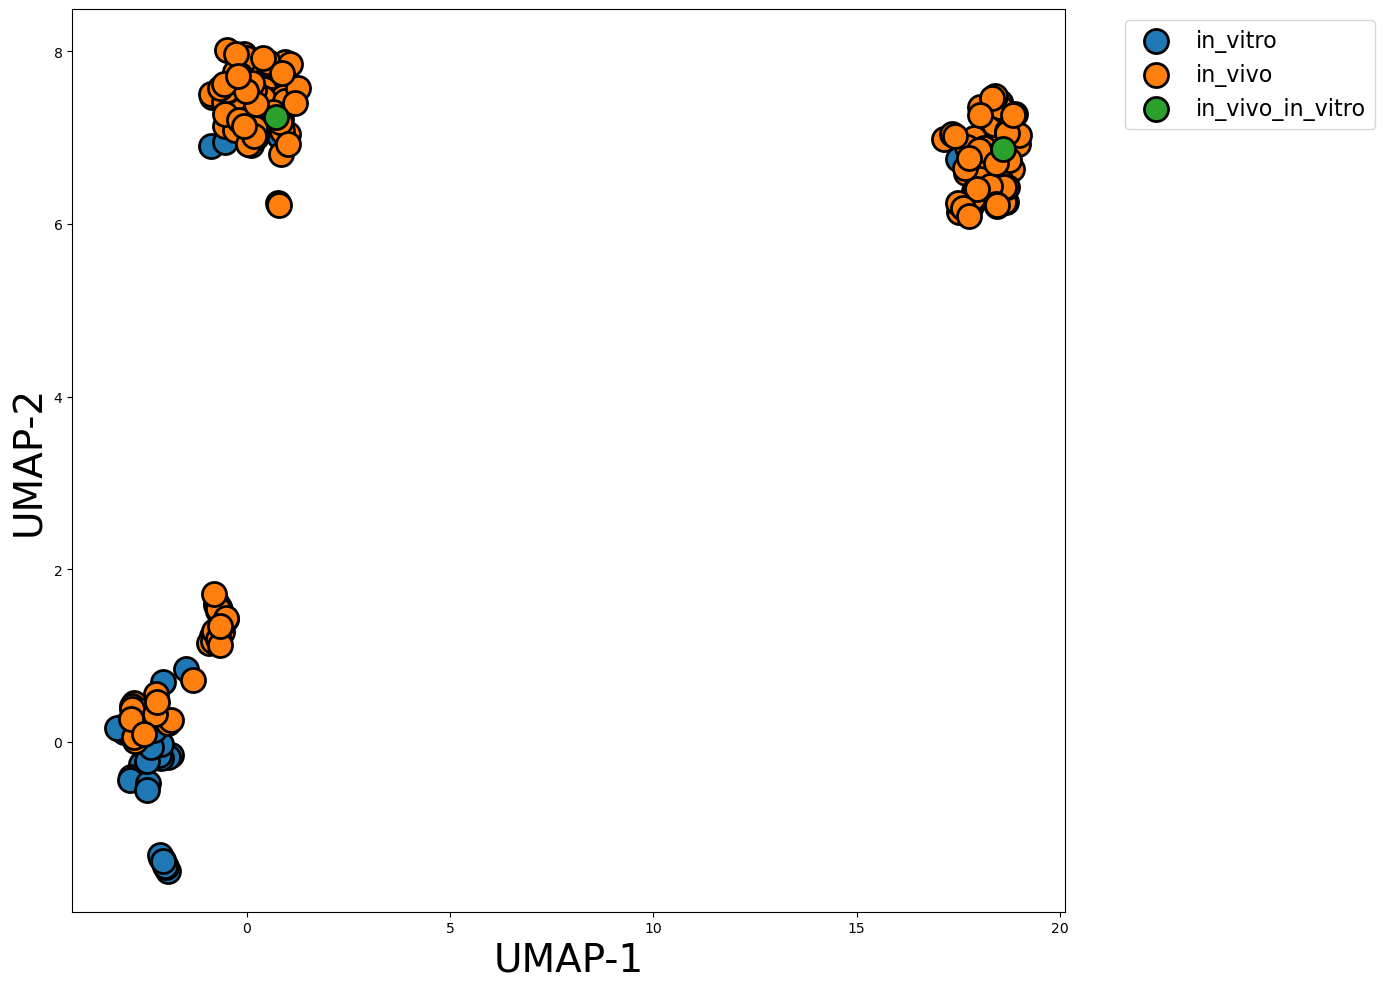

In [17]:
plt.figure(figsize=(14,10))
counter = 1
set_scr_type = set(df_lfc_T_meta['in_vitro_cell_vivo'].unique())
for scr_type in set_scr_type:
    df_temp = df_lfc_T_meta[df_lfc_T_meta['in_vitro_cell_vivo'].values == scr_type]
    plt.scatter(df_temp['u1'], df_temp['u2'], s=300, edgecolors='k', linewidths=2)

plt.legend(list(set_scr_type), fontsize = 16, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('UMAP-1', fontsize = 28)
plt.ylabel('UMAP-2', fontsize = 28)

plt.tight_layout()

file_out = '../../figures/genome_visualizations/UMAP_by_screens.png'
plt.savefig(file_out, dpi = 300)

#### by publication: 

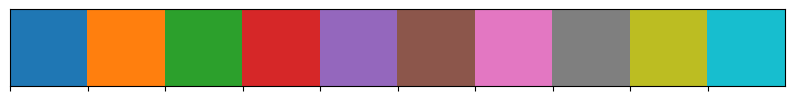

In [18]:
cols = sns.color_palette()
sns.palplot(cols)

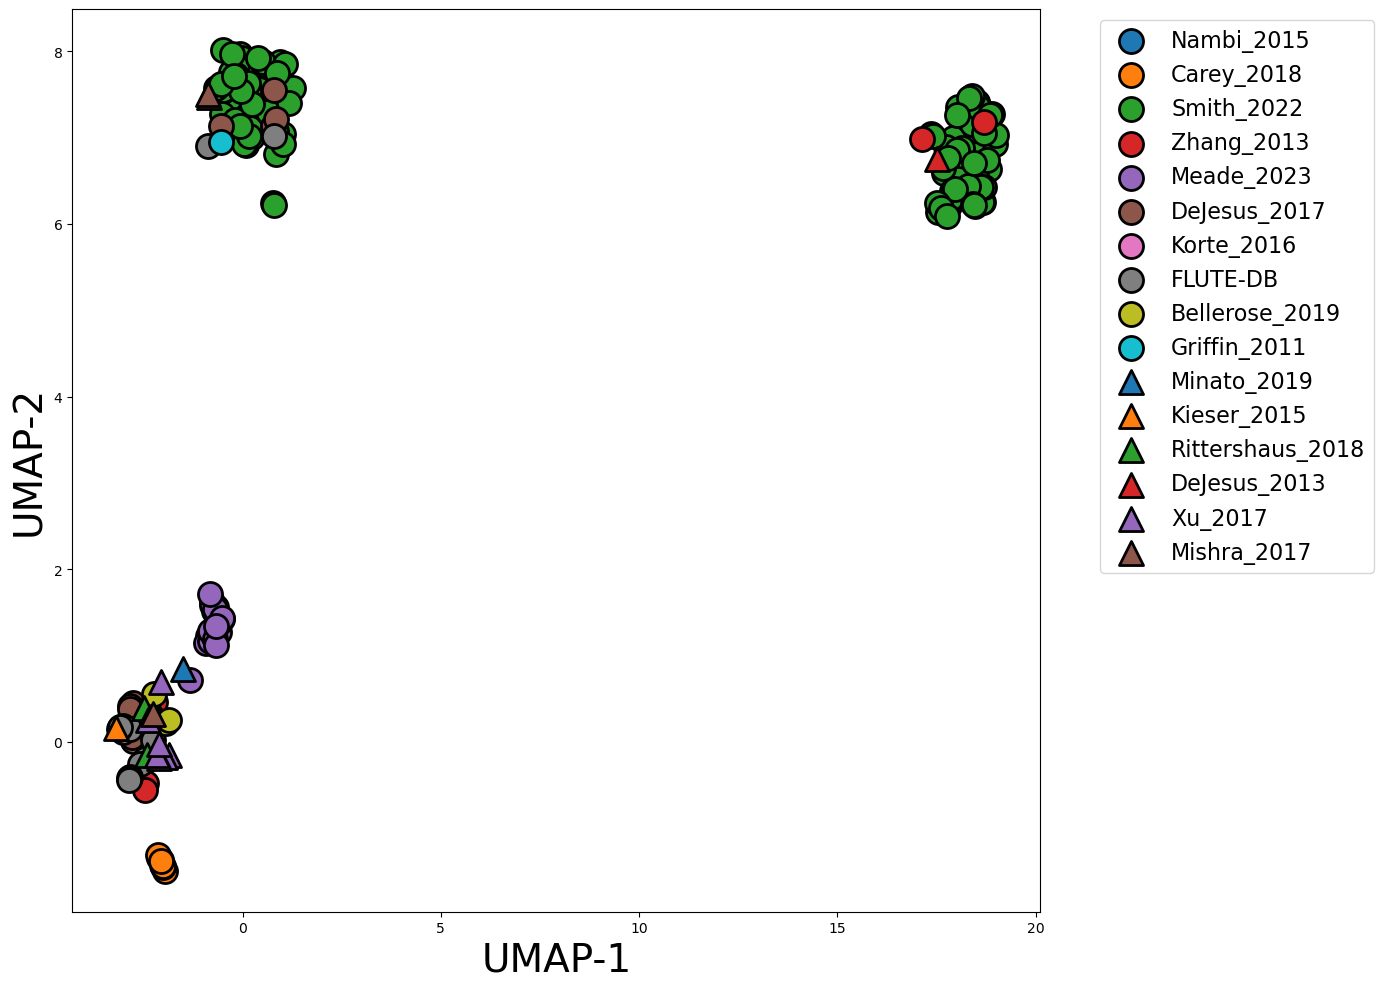

In [19]:
plt.figure(figsize=(14,10))
counter = 1
set_authors = set(df_lfc_T_meta['first_author_year'].unique())
for auth in set_authors:
    df_temp = df_lfc_T_meta[df_lfc_T_meta['first_author_year'].values == auth]
    if counter <= 10:
        plt.scatter(df_temp['u1'], df_temp['u2'], s=300, edgecolors='k', linewidths=2)
    else:
        plt.scatter(df_temp['u1'], df_temp['u2'], s=300, edgecolors='k', linewidths=2, marker='^')
    counter += 1

plt.legend(list(set_authors), fontsize = 16, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('UMAP-1', fontsize = 28)
plt.ylabel('UMAP-2', fontsize = 28)

plt.tight_layout()

file_out = '../../figures/genome_visualizations/UMAP_by_screens_publications.png'
plt.savefig(file_out, dpi = 300)

### Clustering:

binary data: 

In [14]:
cols_to_keep = ['screen','u1', 'u2','u3']
df = df_bin_T[cols_to_keep].copy()

# save to file: 
file_out = '../../data/tests/df_umap_screens.csv'
df.to_csv(file_out, index = False)

data = df[['u1', 'u2', 'u3']].values

NameError: name 'df_bin_T' is not defined

In [ ]:
%%time
wcss, sil = choose_k(data, max_clus = 10)

In [ ]:
wcss_plot = hv.Curve((wcss), label="Within cluster sum of squares").opts(
    xlabel="number of clusters",
    ylabel="WCSS",
    padding=0.1,
    tools=["hover"],
    color="orange",
)
silhouette_plot = hv.Curve((sil), label="silhouette score").opts(
    xlabel="number of clusters", ylabel="silhouette score", padding=0.1, tools=["hover"]
)

In [ ]:
wcss_plot + silhouette_plot.opts(shared_axes = False)

In [ ]:
seed = 43
np.random.seed(seed)
clustering = KMeans(n_clusters = 5, random_state = seed).fit(data)

cluster_labels = clustering.labels_
df['cluster_labels'] = cluster_labels

In [ ]:
df.hvplot.scatter(
    x = 'u1', 
    y = 'u2', 
    c = 'cluster_labels',
    hover_cols = ['screen'],
    padding = 0.2, 
    cmap = cc.glasbey[:5], 
    width = 900, 
    height = 400,
    size = 55,
    alpha = 0.5,
    clabel = 'clusters'
)